## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [5]:
import os
import shutil
import glob

## Arguments & Initializations

In [6]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [7]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [8]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [9]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia1"

In [10]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

cpp_metrics = defaultdict(list) 
cpp_mia_metrics = defaultdict(list)

pr_orig_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [11]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [12]:
dataset_orig.features.shape

(30448, 57)

In [13]:
privileged_groups

[{'age': 1}]

In [14]:
sens_attr

'age'

In [15]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [16]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[  1. 128.   6. ...   0.   1.   0.]
 [  1. 299.   3. ...   0.   1.   0.]
 [  1.  87.   2. ...   1.   0.   0.]
 ...
 [  1.  76.   1. ...   0.   1.   0.]
 [  1. 565.   1. ...   0.   1.   0.]
 [  1. 218.   1. ...   0.   1.   0.]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [17]:
seed = 1234
np.random.seed(seed)

In [18]:
dataset_orig.features

array([[  1., 261.,   1., ...,   0.,   1.,   0.],
       [  1., 226.,   1., ...,   0.,   1.,   0.],
       [  1., 151.,   1., ...,   0.,   1.,   0.],
       ...,
       [  1., 189.,   2., ...,   0.,   1.,   0.],
       [  1., 442.,   1., ...,   0.,   1.,   0.],
       [  0., 239.,   3., ...,   1.,   0.,   0.]])

In [19]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [20]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [21]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [22]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [23]:
def delete_logs():
    # Search for directories ending with _group reor _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [24]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
#         print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )

        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )

        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [ ]:
%matplotlib inline
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    print('ITERATION ', i)
    dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
    
    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)

    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    
#     while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
#         print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
#         dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
#          # check fairness on the original data
#         metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
#                                                      unprivileged_groups=unprivileged_groups,
#                                                      privileged_groups=privileged_groups)
#         print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
#         base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
#         base_rate_privileged = metric_orig_train.base_rate(privileged=True)
        
    print("DIFFERENCE IS GOOD")
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
                
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

ITERATION  0
#### Train dataset's features are as below:
privileged vs. unprivileged:  14354.0 870.0
base_pos unpriv:  0.3022988505747126
base_pos priv:  0.11557753936185036
DIFFERENCE IS GOOD
base_pos unpriv:  0.3022988505747126
base_pos priv:  0.11557753936185036
no bias type specified
#### Training Dataset shape
(15224, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basi

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12695
Number of test samples (ntest): 12723
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1659
Number of test samples (ntest): 1627
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13302
         1.0       0.84      0.72      0.77      1922

    accuracy                           0.95     15224
   macro avg       0.90      0.85      0.87     15224
weighted avg       0.94      0.95      0.94     15224

Train accuracy:  0.946466106148187
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 573
Privileged Positive Predictions (Favorable): 6228
Unprivileged Negative Predictions: 301
Privileged Negative Predictions: 8122
Unprivileged Positive Predictions (Favorable): 530
Privileged Positive Predictions (Favorable): 4212
Unprivileged Negative Predictions: 344
Privileged Negative Pre

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 501
Privileged Positive Predictions (Favorable): 3474
Unprivileged Negative Predictions: 373
Privileged Negative Predictions: 10876
Unprivileged Positive Predictions (Favorable): 488
Privileged Positive Predictions (Favorable): 3424
Unprivileged Negative Predictions: 386
Privileged Negative Predictions: 10926
Unprivileged Positive Predictions (Favorable): 482
Privileged Positive Predictions (Favorable): 3065
Unprivileged Negative Predictions: 392
Privileged Negative Predictions: 11285
Unprivileged Positive Predictions (Favorable): 468
Privileged Positive Predictions (Favorable): 2967
Unprivileged Negative Predictions: 406
Privileged Negative Predictions: 11383
Unprivileged Positive Predictions (Favorable): 468
Privileged Positive Predictions (Favorable): 2951
Unprivileged Negative Predictions: 406
Privileged Negative Predictions: 11399
Unprivileged Positive Predictions (Favorable): 465
Privileged Positive Predictions (Favorable): 2894
Unpr

Size of favorable dataset: 263
Size of inflated unfavorable dataset: 1821
Sample features size:  2084
Sample labels size:  2084
Size of favorable dataset: 607
Size of inflated unfavorable dataset: 12887
Sample features size:  13494
Sample labels size:  13494
origin, transf:  15224 28708
after transf priv:  0.11557753936185036
after transf unpriv:  0.11557753936185036
Difference in mean outcomes between unprivileged and privileged groups = 0.000000
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 309
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12695
Number of test samples (ntest): 12723
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1659
Number of test samples (ntest): 1627
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     25390
         1.0       0.87      0.59      0.71      3318

    accuracy                           0.94     28708
   macro avg       0.91      0.79      0.84     28708
weighted avg       0.94      0.94      0.94     28708

Train accuracy:  0.9428033997491988
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 619
Privileged Positive Predictions (Favorable): 4888
Unprivileged Negative Predictions: 255
Privileged Negative Predictions: 9462
Unprivileged Positive Predictions (Favorable): 587
Privileged Positive Predictions (Favorable): 4888
Unprivileged Negative Predictions: 287
Privileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 470
Privileged Positive Predictions (Favorable): 3867
Unprivileged Negative Predictions: 404
Privileged Negative Predictions: 10483
Unprivileged Positive Predictions (Favorable): 462
Privileged Positive Predictions (Favorable): 3675
Unprivileged Negative Predictions: 412
Privileged Negative Predictions: 10675
Unprivileged Positive Predictions (Favorable): 462
Privileged Positive Predictions (Favorable): 3675
Unprivileged Negative Predictions: 412
Privileged Negative Predictions: 10675
Unprivileged Positive Predictions (Favorable): 365
Privileged Positive Predictions (Favorable): 3189
Unprivileged Negative Predictions: 509
Privileged Negative Predictions: 11161
Unprivileged Positive Predictions (Favorable): 365
Privileged Positive Predictions (Favorable): 3189
Unprivileged Negative Predictions: 509
Privileged Negative Predictions: 11161
Unprivileged Positive Predictions (Favorable): 365
Privileged Positive Predictions (Favorable): 3174
Unpr

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 309
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12695
Number of test samples (ntest): 12723
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1659
Number of test samples (ntest): 1627
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13302
         1.0       0.80      0.74      0.77      1922

    accuracy                           0.94     15224
   macro avg       0.88      0.86      0.87     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9444298476090384
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 568
Privileged Positive Predictions (Favorable): 5810
Unprivileged Negative Predictions: 306
Privileged Negative Predictions: 8540
Unprivileged Positive Predictions (Favorable): 547
Privileged Positive Predictions (Favorable): 4868
Unprivileged Negative Predictions: 327
Privileged Negative Pr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 514
Privileged Positive Predictions (Favorable): 4049
Unprivileged Negative Predictions: 360
Privileged Negative Predictions: 10301
Unprivileged Positive Predictions (Favorable): 490
Privileged Positive Predictions (Favorable): 3407
Unprivileged Negative Predictions: 384
Privileged Negative Predictions: 10943
Unprivileged Positive Predictions (Favorable): 485
Privileged Positive Predictions (Favorable): 3382
Unprivileged Negative Predictions: 389
Privileged Negative Predictions: 10968
Unprivileged Positive Predictions (Favorable): 479
Privileged Positive Predictions (Favorable): 3142
Unprivileged Negative Predictions: 395
Privileged Negative Predictions: 11208
Unprivileged Positive Predictions (Favorable): 478
Privileged Positive Predictions (Favorable): 2971
Unprivileged Negative Predictions: 396
Privileged Negative Predictions: 11379
Unprivileged Positive Predictions (Favorable): 478
Privileged Positive Predictions (Favorable): 2971
Unpr

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 309
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12695
Number of test samples (ntest): 12723
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1659
Number of test samples (ntest): 1627
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13302
         1.0       0.81      0.72      0.76      1922

    accuracy                           0.94     15224
   macro avg       0.89      0.85      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9432475039411455
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 541
Privileged Positive Predictions (Favorable): 5390
Unprivileged Negative Predictions: 333
Privileged Negative Predictions: 8960
Unprivileged Positive Predictions (Favorable): 530
Privileged Positive Predictions (Favorable): 4232
Unprivileged Negative Predictions: 344
Privileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 455
Privileged Positive Predictions (Favorable): 3607
Unprivileged Negative Predictions: 419
Privileged Negative Predictions: 10743
Unprivileged Positive Predictions (Favorable): 453
Privileged Positive Predictions (Favorable): 3448
Unprivileged Negative Predictions: 421
Privileged Negative Predictions: 10902
Unprivileged Positive Predictions (Favorable): 400
Privileged Positive Predictions (Favorable): 2847
Unprivileged Negative Predictions: 474
Privileged Negative Predictions: 11503
Unprivileged Positive Predictions (Favorable): 394
Privileged Positive Predictions (Favorable): 2737
Unprivileged Negative Predictions: 480
Privileged Negative Predictions: 11613
Unprivileged Positive Predictions (Favorable): 394
Privileged Positive Predictions (Favorable): 2723
Unprivileged Negative Predictions: 480
Privileged Negative Predictions: 11627
Unprivileged Positive Predictions (Favorable): 394
Privileged Positive Predictions (Favorable): 2723
Unpr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 309
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12695
Number of test samples (ntest): 12723
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1659
Number of test samples (ntest): 1627
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13302
         1.0       0.75      0.62      0.68      1922

    accuracy                           0.93     15224
   macro avg       0.85      0.79      0.82     15224
weighted avg       0.92      0.93      0.92     15224

Train accuracy:  0.9256437204414083
Validating EG ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 288
Privileged Positive P

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 288
Privileged Positive Predictions (Favorable): 1859
Unprivileged Negative Predictions: 586
Privileged Negative Predictions: 12491
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.43825175291699026
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13302, Test = 13288
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.07858341752829918
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1922, Test = 1936
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR):

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 226
Privileged Positive Predictions (Favorable): 1334
Unprivileged Negative Predictions: 220
Privileged Negative Predictions: 5832
Unprivileged Positive Predictions (Favorable): 212
Privileged Positive Predictions (Favorable): 1190
Unprivileged Negative Predictions: 234
Privileged Negative Predictions: 5976
Unprivileged Positive Predictions (Favorable): 212
Privileged Positive Predictions (Favorable): 1190
Unprivileged Negative Predictions: 234
Privileged Negative Predictions: 5976
Unprivileged Positive Predictions (Favorable): 189
Privileged Positive Predictions (Favorable): 1123
Unprivileged Negative Predictions: 257
Privileged Negative Predictions: 6043
Unprivileged Positive Predictions (Favorable): 187
Privileged Positive Predictions (Favorable): 1118
Unprivileged Negative Predictions: 259
Privileged Negative Predictions: 6048
Unprivileged Positive Predictions (Favorable): 185
Privileged Positive Predictions (Favorable): 1058
Unprivile

privileged vs. unprivileged:  14335.0 889.0
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
DIFFERENCE IS GOOD
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
no bias type specified
#### Training Dataset shape
(15224, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basic.4y', 'education=basic.6y', 'education=basic.9y', 'educa

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13229
         1.0       0.80      0.72      0.76      1995

    accuracy                           0.94     15224
   macro avg       0.88      0.85      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9396347871781398
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 494
Privileged Positive Predictions (Favorable): 4226
Unprivileged Negative Predictions: 361
Privileged Negative Predictions: 10143
Unprivileged Positive Predictions (Favorable): 490
Privileged Positive Predictions (Favorable): 4175
Unprivileged Negative Predictions: 365
Privileged Negative P

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 419
Privileged Positive Predictions (Favorable): 2887
Unprivileged Negative Predictions: 436
Privileged Negative Predictions: 11482
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 394
Privileged Positive Predictions (Favorable): 2809
Unprivileged Negative Predictions: 461
Privileged Negative Predictions: 11560
Unprivileged Positive Predictions (Favorable): 391
Privileged Positive Predictions (Favorable): 2717
Unprivileged Negative Predictions: 464
Privileged Negative Predictions: 11652
Unprivileged Positive Predictions (Favorable): 385
Privileged Positive Predictions (Favorable): 2682
Unpr

Size of favorable dataset: 321
Size of inflated unfavorable dataset: 1704
Sample features size:  2025
Sample labels size:  2025
Size of favorable dataset: 568
Size of inflated unfavorable dataset: 12840
Sample features size:  13408
Sample labels size:  13408
origin, transf:  15224 28669
after transf priv:  0.11677711893965818
after transf unpriv:  0.11678526580159063
Difference in mean outcomes between unprivileged and privileged groups = 0.000008
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     25321
         1.0       0.81      0.49      0.61      3348

    accuracy                           0.93     28669
   macro avg       0.87      0.74      0.79     28669
weighted avg       0.92      0.93      0.92     28669

Train accuracy:  0.9272035997070006
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 652
Privileged Positive Predictions (Favorable): 6353
Unprivileged Negative Predictions: 203
Privileged Negative Predictions: 8016
Unprivileged Positive Predictions (Favorable): 578
Privileged Positive Predictions (Favorable): 4417
Unprivileged Negative Predictions: 277
Privileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 573
Privileged Positive Predictions (Favorable): 4186
Unprivileged Negative Predictions: 282
Privileged Negative Predictions: 10183
Unprivileged Positive Predictions (Favorable): 552
Privileged Positive Predictions (Favorable): 3996
Unprivileged Negative Predictions: 303
Privileged Negative Predictions: 10373
Unprivileged Positive Predictions (Favorable): 551
Privileged Positive Predictions (Favorable): 3978
Unprivileged Negative Predictions: 304
Privileged Negative Predictions: 10391
Unprivileged Positive Predictions (Favorable): 328
Privileged Positive Predictions (Favorable): 3892
Unprivileged Negative Predictions: 527
Privileged Negative Predictions: 10477
Unprivileged Positive Predictions (Favorable): 328
Privileged Positive Predictions (Favorable): 3876
Unprivileged Negative Predictions: 527
Privileged Negative Predictions: 10493
Unprivileged Positive Predictions (Favorable): 235
Privileged Positive Predictions (Favorable): 3864
Unpr

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13229
         1.0       0.79      0.69      0.74      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.83      0.85     15224
weighted avg       0.93      0.94      0.93     15224

Train accuracy:  0.9352338413032054
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 555
Privileged Positive Predictions (Favorable): 4488
Unprivileged Negative Predictions: 300
Privileged Negative Predictions: 9881
Unprivileged Positive Predictions (Favorable): 539
Privileged Positive Predictions (Favorable): 4227
Unprivileged Negative Predictions: 316
Privileged Negative Pr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 454
Privileged Positive Predictions (Favorable): 3175
Unprivileged Negative Predictions: 401
Privileged Negative Predictions: 11194
Unprivileged Positive Predictions (Favorable): 445
Privileged Positive Predictions (Favorable): 3023
Unprivileged Negative Predictions: 410
Privileged Negative Predictions: 11346
Unprivileged Positive Predictions (Favorable): 442
Privileged Positive Predictions (Favorable): 2852
Unprivileged Negative Predictions: 413
Privileged Negative Predictions: 11517
Unprivileged Positive Predictions (Favorable): 439
Privileged Positive Predictions (Favorable): 2842
Unprivileged Negative Predictions: 416
Privileged Negative Predictions: 11527
Unprivileged Positive Predictions (Favorable): 439
Privileged Positive Predictions (Favorable): 2842
Unprivileged Negative Predictions: 416
Privileged Negative Predictions: 11527
Unprivileged Positive Predictions (Favorable): 439
Privileged Positive Predictions (Favorable): 2842
Unpr

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     13229
         1.0       0.79      0.72      0.75      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9376642143983185
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 543
Privileged Positive Predictions (Favorable): 4485
Unprivileged Negative Predictions: 312
Privileged Negative Predictions: 9884
Unprivileged Positive Predictions (Favorable): 526
Privileged Positive Predictions (Favorable): 4358
Unprivileged Negative Predictions: 329
Privileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 422
Privileged Positive Predictions (Favorable): 3158
Unprivileged Negative Predictions: 433
Privileged Negative Predictions: 11211
Unprivileged Positive Predictions (Favorable): 420
Privileged Positive Predictions (Favorable): 3009
Unprivileged Negative Predictions: 435
Privileged Negative Predictions: 11360
Unprivileged Positive Predictions (Favorable): 416
Privileged Positive Predictions (Favorable): 2913
Unprivileged Negative Predictions: 439
Privileged Negative Predictions: 11456
Unprivileged Positive Predictions (Favorable): 407
Privileged Positive Predictions (Favorable): 2832
Unprivileged Negative Predictions: 448
Privileged Negative Predictions: 11537
Unprivileged Positive Predictions (Favorable): 399
Privileged Positive Predictions (Favorable): 2771
Unprivileged Negative Predictions: 456
Privileged Negative Predictions: 11598
Unprivileged Positive Predictions (Favorable): 399
Privileged Positive Predictions (Favorable): 2768
Unpr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13229
         1.0       0.75      0.61      0.67      1995

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9211114030478192
Validating EG ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 314
Privileged Positive P

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 314
Privileged Positive Predictions (Favorable): 2040
Unprivileged Negative Predictions: 541
Privileged Negative Predictions: 12329
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.3963833326905625
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13229, Test = 13361
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1995, Test = 1863
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR)

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 193
Privileged Positive Predictions (Favorable): 1323
Unprivileged Negative Predictions: 245
Privileged Negative Predictions: 5851
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1250
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5924
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5927
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5927
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5927
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1223
Unprivile

#### Train dataset's features are as below:
privileged vs. unprivileged:  14335.0 889.0
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
DIFFERENCE IS GOOD
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
no bias type specified
#### Training Dataset shape
(15224, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basic.4y', 'educa

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13229
         1.0       0.80      0.72      0.76      1995

    accuracy                           0.94     15224
   macro avg       0.88      0.85      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9396347871781398
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 494
Privileged Positive Predictions (Favorable): 4226
Unprivileged Negative Predictions: 361
Privileged Negative Predictions: 10143
Unprivileged Positive Predictions (Favorable): 490
Privileged Positive Predictions (Favorable): 4175
Unprivileged Negative Predictions: 365
Privileged Negative P

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 419
Privileged Positive Predictions (Favorable): 2887
Unprivileged Negative Predictions: 436
Privileged Negative Predictions: 11482
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 394
Privileged Positive Predictions (Favorable): 2809
Unprivileged Negative Predictions: 461
Privileged Negative Predictions: 11560
Unprivileged Positive Predictions (Favorable): 391
Privileged Positive Predictions (Favorable): 2717
Unprivileged Negative Predictions: 464
Privileged Negative Predictions: 11652
Unprivileged Positive Predictions (Favorable): 385
Privileged Positive Predictions (Favorable): 2682
Unpr

Size of favorable dataset: 321
Size of inflated unfavorable dataset: 1704
Sample features size:  2025
Sample labels size:  2025
Size of favorable dataset: 568
Size of inflated unfavorable dataset: 12840
Sample features size:  13408
Sample labels size:  13408
origin, transf:  15224 28669
after transf priv:  0.11677711893965818
after transf unpriv:  0.11678526580159063
Difference in mean outcomes between unprivileged and privileged groups = 0.000008
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     25321
         1.0       0.81      0.49      0.61      3348

    accuracy                           0.93     28669
   macro avg       0.87      0.74      0.79     28669
weighted avg       0.92      0.93      0.92     28669

Train accuracy:  0.9272035997070006
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 652
Privileged Positive Predictions (Favorable): 6353
Unprivileged Negative Predictions: 203
Privileged Negative Predictions: 8016
Unprivileged Positive Predictions (Favorable): 578
Privileged Positive Predictions (Favorable): 4417
Unprivileged Negative Predictions: 277
Privileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 552
Privileged Positive Predictions (Favorable): 3996
Unprivileged Negative Predictions: 303
Privileged Negative Predictions: 10373
Unprivileged Positive Predictions (Favorable): 551
Privileged Positive Predictions (Favorable): 3978
Unprivileged Negative Predictions: 304
Privileged Negative Predictions: 10391
Unprivileged Positive Predictions (Favorable): 328
Privileged Positive Predictions (Favorable): 3892
Unprivileged Negative Predictions: 527
Privileged Negative Predictions: 10477
Unprivileged Positive Predictions (Favorable): 328
Privileged Positive Predictions (Favorable): 3876
Unprivileged Negative Predictions: 527
Privileged Negative Predictions: 10493
Unprivileged Positive Predictions (Favorable): 235
Privileged Positive Predictions (Favorable): 3864
Unprivileged Negative Predictions: 620
Privileged Negative Predictions: 10505
Unprivileged Positive Predictions (Favorable): 234
Privileged Positive Predictions (Favorable): 3374
Unpr

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13229
         1.0       0.79      0.69      0.74      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.83      0.85     15224
weighted avg       0.93      0.94      0.93     15224

Train accuracy:  0.9352338413032054
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 555
Privileged Positive Predictions (Favorable): 4488
Unprivileged Negative Predictions: 300
Privileged Negative Predictions: 9881
Unprivileged Positive Predictions (Favorable): 539
Privileged Positive Predictions (Favorable): 4227
Unprivileged Negative Predictions: 316
Privileged Negative Pr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 506
Privileged Positive Predictions (Favorable): 3620
Unprivileged Negative Predictions: 349
Privileged Negative Predictions: 10749
Unprivileged Positive Predictions (Favorable): 484
Privileged Positive Predictions (Favorable): 3314
Unprivileged Negative Predictions: 371
Privileged Negative Predictions: 11055
Unprivileged Positive Predictions (Favorable): 480
Privileged Positive Predictions (Favorable): 3308
Unprivileged Negative Predictions: 375
Privileged Negative Predictions: 11061
Unprivileged Positive Predictions (Favorable): 454
Privileged Positive Predictions (Favorable): 3175
Unprivileged Negative Predictions: 401
Privileged Negative Predictions: 11194
Unprivileged Positive Predictions (Favorable): 445
Privileged Positive Predictions (Favorable): 3023
Unprivileged Negative Predictions: 410
Privileged Negative Predictions: 11346
Unprivileged Positive Predictions (Favorable): 442
Privileged Positive Predictions (Favorable): 2852
Unpr

Unprivileged Positive Predictions (Favorable): 484
Privileged Positive Predictions (Favorable): 3314
Unprivileged Negative Predictions: 371
Privileged Negative Predictions: 11055
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.9028677115420145
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13229, Test = 13361
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predictive value: 0.50
  Optimal thershold: -0.5500463369192721
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1995, Test = 1863
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.62
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.46
  Attacker advan

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     13229
         1.0       0.79      0.72      0.75      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9376642143983185
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 543
Privileged Positive Predictions (Favorable): 4485
Unprivileged Nega

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 423
Privileged Positive Predictions (Favorable): 3186
Unprivileged Negative Predictions: 432
Privileged Negative Predictions: 11183
Unprivileged Positive Predictions (Favorable): 423
Privileged Positive Predictions (Favorable): 3186
Unprivileged Negative Predictions: 432
Privileged Negative Predictions: 11183
Unprivileged Positive Predictions (Favorable): 423
Privileged Positive Predictions (Favorable): 3169
Unprivileged Negative Predictions: 432
Privileged Negative Predictions: 11200
Unprivileged Positive Predictions (Favorable): 422
Privileged Positive Predictions (Favorable): 3158
Unprivileged Negative Predictions: 433
Privileged Negative Predictions: 11211
Unprivileged Positive Predictions (Favorable): 420
Privileged Positive Predictions (Favorable): 3009
Unprivileged Negative Predictions: 435
Privileged Negative Predictions: 11360
Unprivileged Positive Predictions (Favorable): 416
Privileged Positive Predictions (Favorable): 2913
Unpr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13229
         1.0       0.75      0.61      0.67      1995

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9211114030478192
Validating EG ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 314
Privileged Positive P

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 314
Privileged Positive Predictions (Favorable): 2040
Unprivileged Negative Predictions: 541
Privileged Negative Predictions: 12329
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.3963833326905625
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13229, Test = 13361
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1995, Test = 1863
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR)

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 198
Privileged Positive Predictions (Favorable): 1334
Unprivileged Negative Predictions: 240
Privileged Negative Predictions: 5840
Unprivileged Positive Predictions (Favorable): 193
Privileged Positive Predictions (Favorable): 1323
Unprivileged Negative Predictions: 245
Privileged Negative Predictions: 5851
Unprivileged Positive Predictions (Favorable): 193
Privileged Positive Predictions (Favorable): 1323
Unprivileged Negative Predictions: 245
Privileged Negative Predictions: 5851
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1250
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5924
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5927
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivile

#### Train dataset's features are as below:
privileged vs. unprivileged:  14335.0 889.0
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
DIFFERENCE IS GOOD
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
no bias type specified
#### Training Dataset shape
(15224, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basic.4y', 'educa

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13229
         1.0       0.80      0.72      0.76      1995

    accuracy                           0.94     15224
   macro avg       0.88      0.85      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9396347871781398
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 494
Privileged Positive Predictions (Favorable): 4226
Unprivileged Negative Predictions: 361
Privileged Negative Predictions: 10143
Unprivileged Positive Predictions (Favorable): 490
Privileged Positive Predictions (Favorable): 4175
Unprivileged Negative Predictions: 365
Privileged Negative P

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 435
Privileged Positive Predictions (Favorable): 3177
Unprivileged Negative Predictions: 420
Privileged Negative Predictions: 11192
Unprivileged Positive Predictions (Favorable): 419
Privileged Positive Predictions (Favorable): 2887
Unprivileged Negative Predictions: 436
Privileged Negative Predictions: 11482
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 394
Privileged Positive Predictions (Favorable): 2809
Unprivileged Negative Predictions: 461
Privileged Negative Predictions: 11560
Unprivileged Positive Predictions (Favorable): 391
Privileged Positive Predictions (Favorable): 2717
Unpr

Size of favorable dataset: 321
Size of inflated unfavorable dataset: 1704
Sample features size:  2025
Sample labels size:  2025
Size of favorable dataset: 568
Size of inflated unfavorable dataset: 12840
Sample features size:  13408
Sample labels size:  13408
origin, transf:  15224 28669
after transf priv:  0.11677711893965818
after transf unpriv:  0.11678526580159063
Difference in mean outcomes between unprivileged and privileged groups = 0.000008
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     25321
         1.0       0.81      0.49      0.61      3348

    accuracy                           0.93     28669
   macro avg       0.87      0.74      0.79     28669
weighted avg       0.92      0.93      0.92     28669

Train accuracy:  0.9272035997070006
Validating Syn OR Rew ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 652
Privileged Positive Predictions (Favorable): 6353
Unprivileged Negative Predictions: 203
Privileged Negative Predictions: 8016
Unprivileged Positive Predictions (Favorable): 578
Privileged Positive Predictions (Favorable): 4417
Unprivileged Negative Predictions: 277
Privileged Negative Predictions: 9952
Unprivileged Positive Predictions (Favorable): 573
Privileged Positive Predictions (Favorable): 4200
Unprivileged Negative Predictions: 282
Privileged Negative Predictions: 10169
Unprivileged Positive Predictions (Favorable): 573
Privileged Positive Predictions (Favorable): 4186
Unprivileged Negative Predictions: 282
Privileged Negative Predictions: 10183
Unprivileged Positive Predictions (Favorable): 552
Privileged Positive Predictions (Favorable): 3996
Unprivileged Negative Predictions: 303
Privileged Negative Predictions: 10373
Unprivileged Positive Predictions (Favorable): 551
Privileged Positive Predictions (Fav

Unprivileged Positive Predictions (Favorable): 121
Privileged Positive Predictions (Favorable): 1194
Unprivileged Negative Predictions: 734
Privileged Negative Predictions: 13175
Best thresh:  0.060000000000000005
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 551
Privileged Positive Predictions (Favorable): 3978
Unprivileged Negative Predictions: 304
Privileged Negative Predictions: 10391
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.916290731874155
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13229, Test = 13361
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.02
  Positive predictive value: 0.50

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13229
         1.0       0.79      0.69      0.74      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.83      0.85     15224
weighted avg       0.93      0.94      0.93     15224

Train accuracy:  0.9352338413032054
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 555
Privileged Positive Prediction

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 454
Privileged Positive Predictions (Favorable): 3175
Unprivileged Negative Predictions: 401
Privileged Negative Predictions: 11194
Unprivileged Positive Predictions (Favorable): 445
Privileged Positive Predictions (Favorable): 3023
Unprivileged Negative Predictions: 410
Privileged Negative Predictions: 11346
Unprivileged Positive Predictions (Favorable): 442
Privileged Positive Predictions (Favorable): 2852
Unprivileged Negative Predictions: 413
Privileged Negative Predictions: 11517
Unprivileged Positive Predictions (Favorable): 439
Privileged Positive Predictions (Favorable): 2842
Unprivileged Negative Predictions: 416
Privileged Negative Predictions: 11527
Unprivileged Positive Predictions (Favorable): 439
Privileged Positive Predictions (Favorable): 2842
Unprivileged Negative Predictions: 416
Privileged Negative Predictions: 11527
Unprivileged Positive Predictions (Favorable): 439
Privileged Positive Predictions (Favorable): 2842
Unpr

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     13229
         1.0       0.79      0.72      0.75      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9376642143983185
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 543
Privileged Positive Predictions (Favorable): 4485
Unprivileged Negative Predictions: 312
Privileged Negative Predictions: 9884


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 526
Privileged Positive Predictions (Favorable): 4358
Unprivileged Negative Predictions: 329
Privileged Negative Predictions: 10011
Unprivileged Positive Predictions (Favorable): 491
Privileged Positive Predictions (Favorable): 4178
Unprivileged Negative Predictions: 364
Privileged Negative Predictions: 10191
Unprivileged Positive Predictions (Favorable): 454
Privileged Positive Predictions (Favorable): 3591
Unprivileged Negative Predictions: 401
Privileged Negative Predictions: 10778
Unprivileged Positive Predictions (Favorable): 447
Privileged Positive Predictions (Favorable): 3513
Unprivileged Negative Predictions: 408
Privileged Negative Predictions: 10856
Unprivileged Positive Predictions (Favorable): 423
Privileged Positive Predictions (Favorable): 3186
Unprivileged Negative Predictions: 432
Privileged Negative Predictions: 11183
Unprivileged Positive Predictions (Favorable): 423
Privileged Positive Predictions (Favorable): 3186
Unpr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13229
         1.0       0.75      0.61      0.67      1995

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9211114030478192
Validating EG ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 314
Privileged Positive P

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 314
Privileged Positive Predictions (Favorable): 2040
Unprivileged Negative Predictions: 541
Privileged Negative Predictions: 12329
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.3963833326905625
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13229, Test = 13361
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1995, Test = 1863
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR)

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1250
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5924
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5927
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5927
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1247
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5927
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1223
Unprivileged Negative Predictions: 247
Privileged Negative Predictions: 5951
Unprivileged Positive Predictions (Favorable): 191
Privileged Positive Predictions (Favorable): 1223
Unprivile

privileged vs. unprivileged:  14335.0 889.0
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
DIFFERENCE IS GOOD
base_pos unpriv:  0.3610798650168729
base_pos priv:  0.11677711893965818
no bias type specified
#### Training Dataset shape
(15224, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'education=basic.4y', 'education=basic.6y', 'education=basic.9y', 'educa

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13229
         1.0       0.80      0.72      0.76      1995

    accuracy                           0.94     15224
   macro avg       0.88      0.85      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9396347871781398
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 494
Privileged Positive Predictions (Favorable): 4226
Unprivileged Negative Predictions: 361
Privileged Negative Predictions: 10143
Unprivileged Positive Predictions (Favorable): 490
Privileged Positive Predictions (Favorable): 4175
Unprivileged Negative Predictions: 365
Privileged Negative P

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 435
Privileged Positive Predictions (Favorable): 3177
Unprivileged Negative Predictions: 420
Privileged Negative Predictions: 11192
Unprivileged Positive Predictions (Favorable): 419
Privileged Positive Predictions (Favorable): 2887
Unprivileged Negative Predictions: 436
Privileged Negative Predictions: 11482
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 395
Privileged Positive Predictions (Favorable): 2876
Unprivileged Negative Predictions: 460
Privileged Negative Predictions: 11493
Unprivileged Positive Predictions (Favorable): 394
Privileged Positive Predictions (Favorable): 2809
Unprivileged Negative Predictions: 461
Privileged Negative Predictions: 11560
Unprivileged Positive Predictions (Favorable): 391
Privileged Positive Predictions (Favorable): 2717
Unpr

Size of favorable dataset: 568
Size of inflated unfavorable dataset: 12840
Sample features size:  13408
Sample labels size:  13408
origin, transf:  15224 28669
after transf priv:  0.11677711893965818
after transf unpriv:  0.11678526580159063
Difference in mean outcomes between unprivileged and privileged groups = 0.000008
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     25321
         1.0       0.81      0.49      0.61      3348

    accuracy                           0.93     28669
   macro avg       0.87      0.74      0.79     28669
weighted avg       0.92      0.93      0.92     28669

Train accuracy:  0.9272035997070006
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 652
Privileged Positive Predictions (Favorable): 6353
Unprivileged Negative Predictions: 203
Privileged Negative Predictions: 8016
Unprivileged Positive Predictions (Favorable): 578
Privileged Positive Predictions (Favorable): 4417
Unprivileged Negative Predictions: 277
Privileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 552
Privileged Positive Predictions (Favorable): 3996
Unprivileged Negative Predictions: 303
Privileged Negative Predictions: 10373
Unprivileged Positive Predictions (Favorable): 551
Privileged Positive Predictions (Favorable): 3978
Unprivileged Negative Predictions: 304
Privileged Negative Predictions: 10391
Unprivileged Positive Predictions (Favorable): 328
Privileged Positive Predictions (Favorable): 3892
Unprivileged Negative Predictions: 527
Privileged Negative Predictions: 10477
Unprivileged Positive Predictions (Favorable): 328
Privileged Positive Predictions (Favorable): 3876
Unprivileged Negative Predictions: 527
Privileged Negative Predictions: 10493
Unprivileged Positive Predictions (Favorable): 235
Privileged Positive Predictions (Favorable): 3864
Unprivileged Negative Predictions: 620
Privileged Negative Predictions: 10505
Unprivileged Positive Predictions (Favorable): 234
Privileged Positive Predictions (Favorable): 3374
Unpr

RUN DIRMITIGATOR
[INFO]: training decision tree
RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13229
         1.0       0.79      0.69      0.74      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.83      0.85     15224
weighted avg       0.93      0.94      0.93     15224

Train accuracy:  0.9352338413032054
Validating Original ...


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 555
Privileged Positive Predictions (Favorable): 4488
Unprivileged Negative Predictions: 300
Privileged Negative Predictions: 9881
Unprivileged Positive Predictions (Favorable): 539
Privileged Positive Predictions (Favorable): 4227
Unprivileged Negative Predictions: 316
Privileged Negative Predictions: 10142
Unprivileged Positive Predictions (Favorable): 529
Privileged Positive Predictions (Favorable): 4121
Unprivileged Negative Predictions: 326
Privileged Negative Predictions: 10248
Unprivileged Positive Predictions (Favorable): 506
Privileged Positive Predictions (Favorable): 3620
Unprivileged Negative Predictions: 349
Privileged Negative Predictions: 10749
Unprivileged Positive Predictions (Favorable): 484
Privileged Positive Predictions (Favorable): 3314
Unprivileged Negative Predictions: 371
Privileged Negative Predictions: 11055
Unprivileged Positive Predictions (Favorable): 480
Privileged Positive Prediction

MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 568, Test = 604
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.13
  Positive predictive value: 0.56
  Optimal thershold: -0.20067069546215124
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 321, Test = 251
  AUC: 0.62
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.26
  Positive predictive value: 0.65
  Optimal thershold: -0.8602012652231115
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Dataset: Train = 12661, Test = 12757
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.5500463369192721
)
MIA_Result(
  Name: subpopulation_1.0_label_1.0
  Size of the Dataset: Train 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     13229
         1.0       0.79      0.72      0.75      1995

    accuracy                           0.94     15224
   macro avg       0.87      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9376642143983185
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 543
Privileged Positive Predictions (Favorable): 4485
Unprivileged Negative Predictions: 312
Privileged Negative Predictions: 9884
Unprivileged Positive Predictions (Favorable): 526
Privileged Positive Predictions (Favorable): 4358
Unprivileged Negative Predictions: 329
Privileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 423
Privileged Positive Predictions (Favorable): 3169
Unprivileged Negative Predictions: 432
Privileged Negative Predictions: 11200
Unprivileged Positive Predictions (Favorable): 422
Privileged Positive Predictions (Favorable): 3158
Unprivileged Negative Predictions: 433
Privileged Negative Predictions: 11211
Unprivileged Positive Predictions (Favorable): 420
Privileged Positive Predictions (Favorable): 3009
Unprivileged Negative Predictions: 435
Privileged Negative Predictions: 11360
Unprivileged Positive Predictions (Favorable): 416
Privileged Positive Predictions (Favorable): 2913
Unprivileged Negative Predictions: 439
Privileged Negative Predictions: 11456
Unprivileged Positive Predictions (Favorable): 407
Privileged Positive Predictions (Favorable): 2832
Unprivileged Negative Predictions: 448
Privileged Negative Predictions: 11537
Unprivileged Positive Predictions (Favorable): 399
Privileged Positive Predictions (Favorable): 2771
Unpr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12661
Number of test samples (ntest): 12757
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1674
Number of test samples (ntest): 1612
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13229
         1.0       0.75      0.61      0.67      1995

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9211114030478192
Validating EG ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 314
Privileged Positive P

[INFO]: training decision tree
Accuracies Comparison:
----------------------------------------------------------------------
Group          CPP Train           CPP Test            
----------------------------------------------------------------------
UF Unpriv      0.8944              0.7946              
UF Priv        1.0000              1.0000              
F Unpriv       0.8598              0.5417              
F Priv         0.0000              0.0000              
----------------------------------------------------------------------
RUN MIA ATTACK
SCORES TRAIN:  [[0.11485921]
 [0.11485921]
 [0.11485921]
 ...
 [0.11485921]
 [0.11485921]
 [0.11485921]]
SCORES TEST:  [[0.11485921]
 [0.11485921]
 [1.        ]
 ...
 [0.11485921]
 [0.11485921]
 [0.11485921]]
DIFFERENCE COUNT:  830
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 297
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test sam

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Unprivileged Positive Predictions (Favorable): 207
Privileged Positive Predictions (Favorable): 1441
Unprivileged Negative Predictions: 231
Privileged Negative Predictions: 5733
Unprivileged Positive Predictions (Favorable): 206
Privileged Positive Predictions (Favorable): 1413
Unprivileged Negative Predictions: 232
Privileged Negative Predictions: 5761
Unprivileged Positive Predictions (Favorable): 205
Privileged Positive Predictions (Favorable): 1363
Unprivileged Negative Predictions: 233
Privileged Negative Predictions: 5811
Unprivileged Positive Predictions (Favorable): 202
Privileged Positive Predictions (Favorable): 1350
Unprivileged Negative Predictions: 236
Privileged Negative Predictions: 5824
Unprivileged Positive Predictions (Favorable): 198
Privileged Positive Predictions (Favorable): 1334
Unprivileged Negative Predictions: 240
Privileged Negative Predictions: 5840
Unprivileged Positive Predictions (Favorable): 193
Privileged Positive Predictions (Favorable): 1323
Unprivile

RUN MIA ATTACK
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 568
Number of test samples (ntest): 604
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 321
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [27]:
df_bank.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid',
       'job=management', 'job=retired', 'job=self-employed', 'job=services',
       'job=student', 'job=technician', 'job=unemployed', 'marital=divorced',
       'marital=married', 'marital=single', 'education=basic.4y',
       'education=basic.6y', 'education=basic.9y', 'education=high.school',
       'education=illiterate', 'education=professional.course',
       'education=university.degree', 'default=no', 'default=yes',
       'housing=no', 'housing=yes', 'loan=no', 'loan=yes', 'contact=cellular',
       'contact=telephone', 'month=apr', 'month=aug', 'month=dec', 'month=jul',
       'month=jun', 'month=mar', 'month=may', 'month=nov', 'month=oct',
       'month=sep', 'day_of_week=fri', 'day_of_week=mon', 'day_of_week=thu',
       'day_of_week=tue', 'day_of_week=wed

In [28]:
df_bank[df_bank['y'] == 1]['age'].value_counts()

age
1.0    3286
0.0     572
Name: count, dtype: int64

In [29]:
# Count the occurrences of privileged and unprivileged values
age_counts = df_bank['age'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Age')
plt.xlabel('Age Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

C:\Users\ilham\AppData\Local\Temp\ipykernel_21836\3099988083.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [30]:
y_counts = df_bank['y'].value_counts()

In [31]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

C:\Users\ilham\AppData\Local\Temp\ipykernel_21836\3133446903.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [32]:
df_bank.shape

(30448, 58)

## Display Output

In [33]:
priv_metric_orig_copy = priv_metric_orig

In [34]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 286719.0, 'total_unpriv': 17761.0})

In [35]:
priv_metric_orig

defaultdict(float, {'total_priv': 286719.0, 'total_unpriv': 17761.0})

In [36]:
priv_metric_orig.items()

dict_items([('total_priv', 286719.0), ('total_unpriv', 17761.0)])

In [36]:
priv_metric_orig = priv_metric_orig_copy

In [37]:
orig_metrics.items()

dict_items([('bal_acc', [0.8265198265010125, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529]), ('avg_odds_diff', [0.1299023504661376, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016]), ('disp_imp', [0.5776703039913205, 0.6168750761105735, 0.6168750761105735, 0.6168750761105735, 0.6168750761105735, 0.6168750761105735,

In [38]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

bank
15224
2)

              total_priv  total_unpriv
num_instance                          
orig             14325.5         898.5
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.128245       0.871755    0.116603      0.883397      0.313837   
transf      0.116603       0.883397    0.116603      0.883397      0.116603   

         unpriv_unfavor  
dataset                  
orig           0.686163  
transf         0.883397  


In [39]:
orig_metrics.items()

dict_items([('bal_acc', [0.8265198265010125, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529, 0.8290794470941529]), ('avg_odds_diff', [0.1299023504661376, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016, 0.13694088171771016]), ('disp_imp', [0.5776703039913205, 0.6168750761105735, 0.6168750761105735, 0.6168750761105735, 0.6168750761105735, 0.6168750761105735,

In [40]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

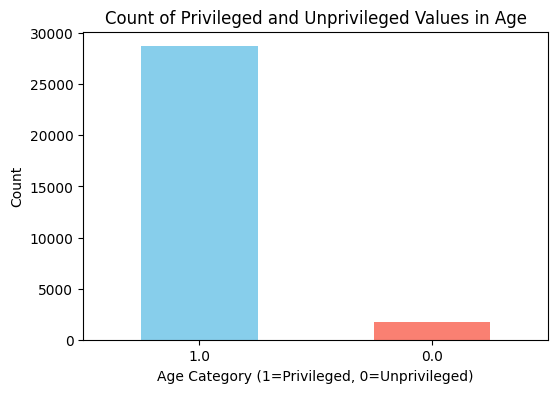

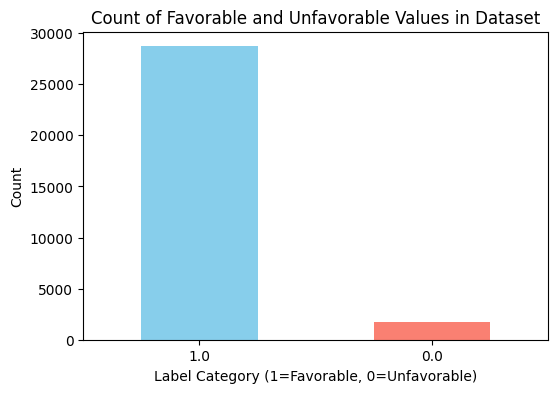

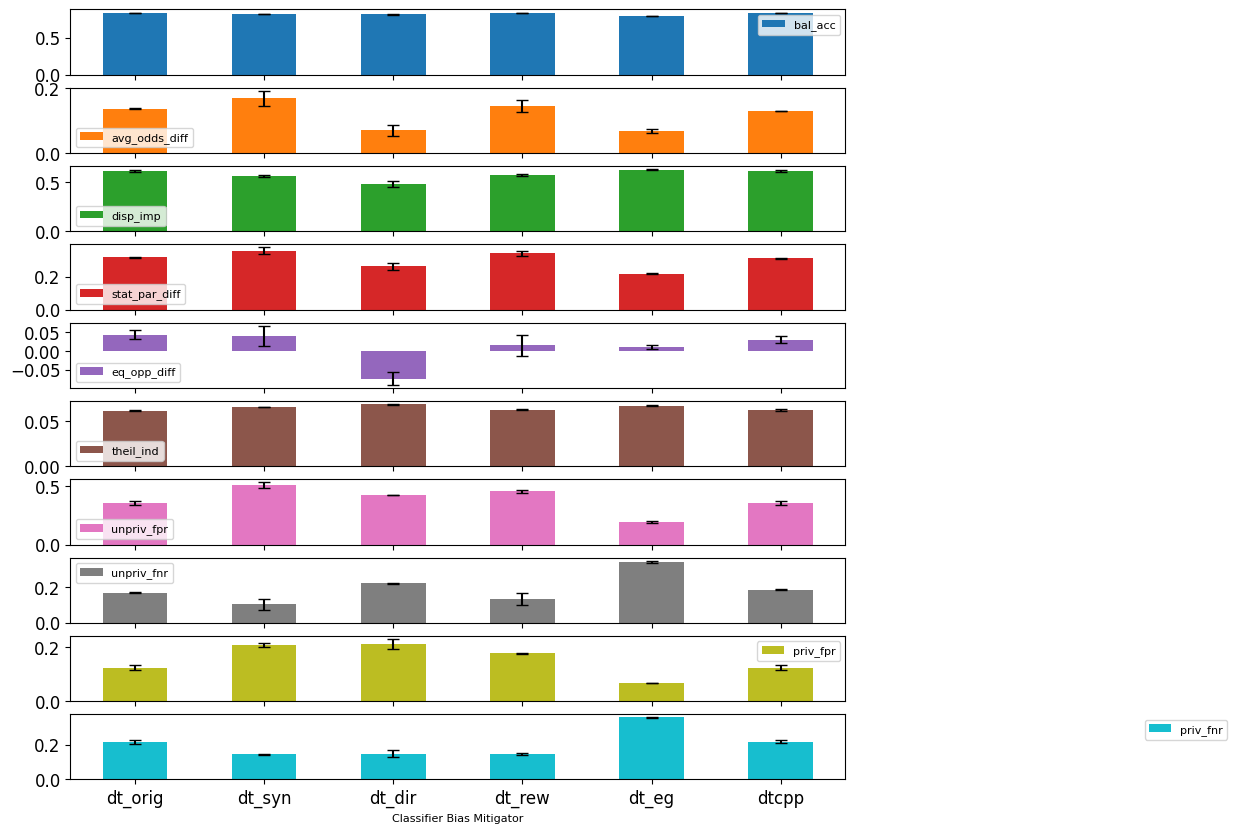

In [41]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean,
#         pr_orig_metrics_mean,
        cpp_metrics_mean]
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics,
#         pr_orig_error_metrics,
        cpp_error_metrics]
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'] + [model_type + 'cpp'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [42]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in cpp_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [43]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean,
           cpp_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics,
          cpp_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'] + ['cpp'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.522253,0.514124,0.587639,0.553168,0.584818,0.513741,0.592533
syn,0.517742,0.510819,0.575905,0.558709,0.570573,0.509448,0.577521
dir,0.555125,0.551565,0.589895,0.590797,0.631343,0.550146,0.585636
rew,0.521313,0.512755,0.591276,0.552983,0.581846,0.511152,0.594119
eg,0.514308,0.510064,0.559263,0.557931,0.571926,0.508190,0.559067
cpp,0.501747,0.502372,0.500000,0.500000,0.500000,0.500000,0.500000


In [44]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [45]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
        'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [46]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.553168,0.513741,0.584818,0.592533
syn,0.558709,0.509448,0.570573,0.577521
dir,0.590797,0.550146,0.631343,0.585636
rew,0.552983,0.511152,0.581846,0.594119
eg,0.557931,0.508190,0.571926,0.559067
cpp,0.500000,0.500000,0.500000,0.500000


<Axes: xlabel='Classifier MIA Attacks'>

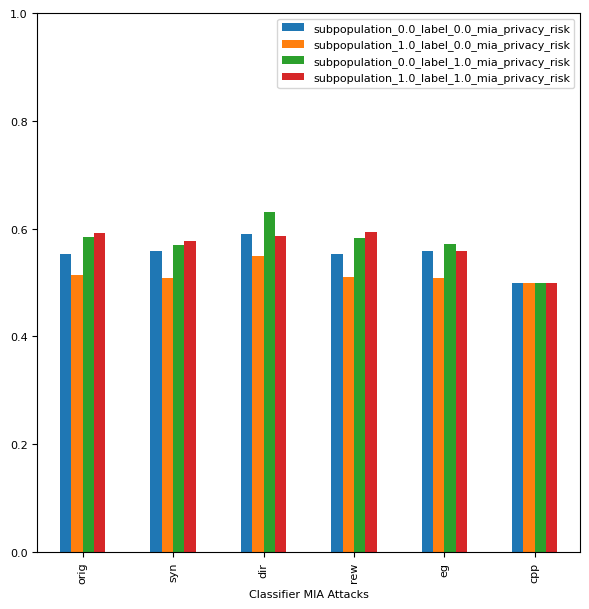

In [47]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [48]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg    cpp
--------------------------------------------  --------  --------  --------  --------  --------  -----
subpopulation_0.0_label_0.0_mia_privacy_risk  0.553168  0.558709  0.590797  0.552983  0.557931    0.5
subpopulation_1.0_label_0.0_mia_privacy_risk  0.513741  0.509448  0.550146  0.511152  0.50819     0.5
subpopulation_0.0_label_1.0_mia_privacy_risk  0.584818  0.570573  0.631343  0.581846  0.571926    0.5
subpopulation_1.0_label_1.0_mia_privacy_risk  0.592533  0.577521  0.585636  0.594119  0.559067    0.5


### Visualizing using novel technique

In [49]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [50]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [51]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.528836
1,orig,entire_dataset_mia_privacy_risk,0.521906
2,orig,entire_dataset_mia_privacy_risk,0.521906
3,orig,entire_dataset_mia_privacy_risk,0.521906
4,orig,entire_dataset_mia_privacy_risk,0.521906
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651


In [52]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.528836
1,orig,entire_dataset_mia_privacy_risk,0.521906
2,orig,entire_dataset_mia_privacy_risk,0.521906
3,orig,entire_dataset_mia_privacy_risk,0.521906
4,orig,entire_dataset_mia_privacy_risk,0.521906
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558651


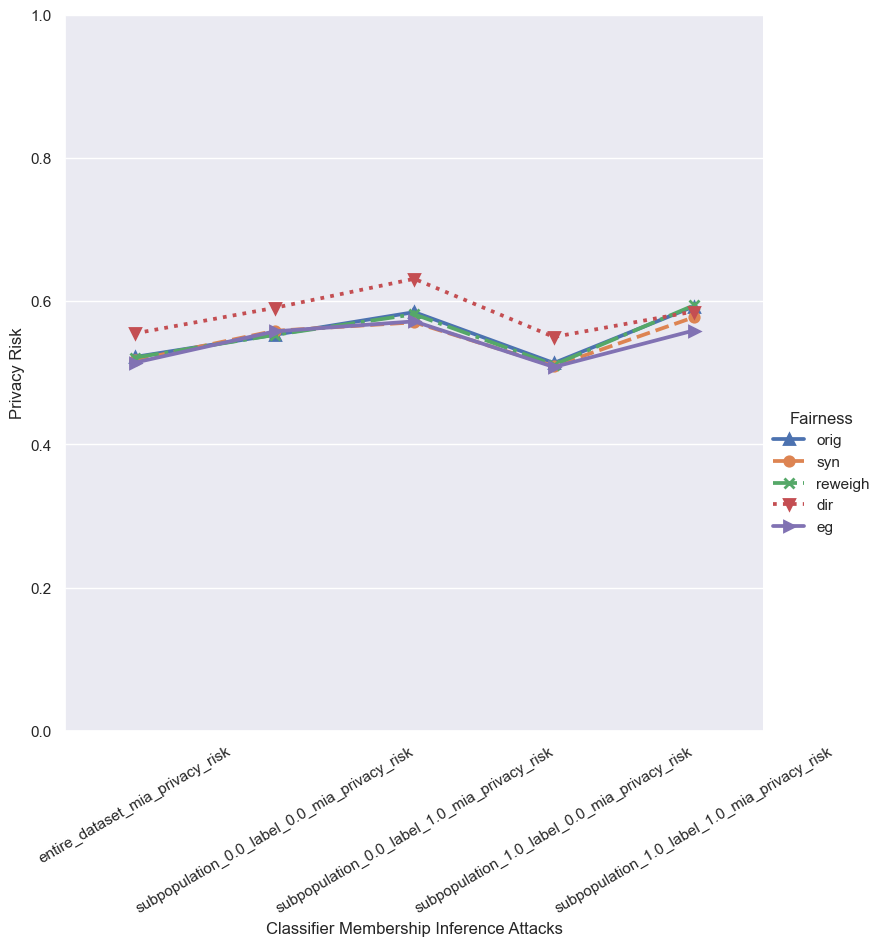

In [53]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [54]:
from sklearn.metrics import RocCurveDisplay, auc

In [55]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

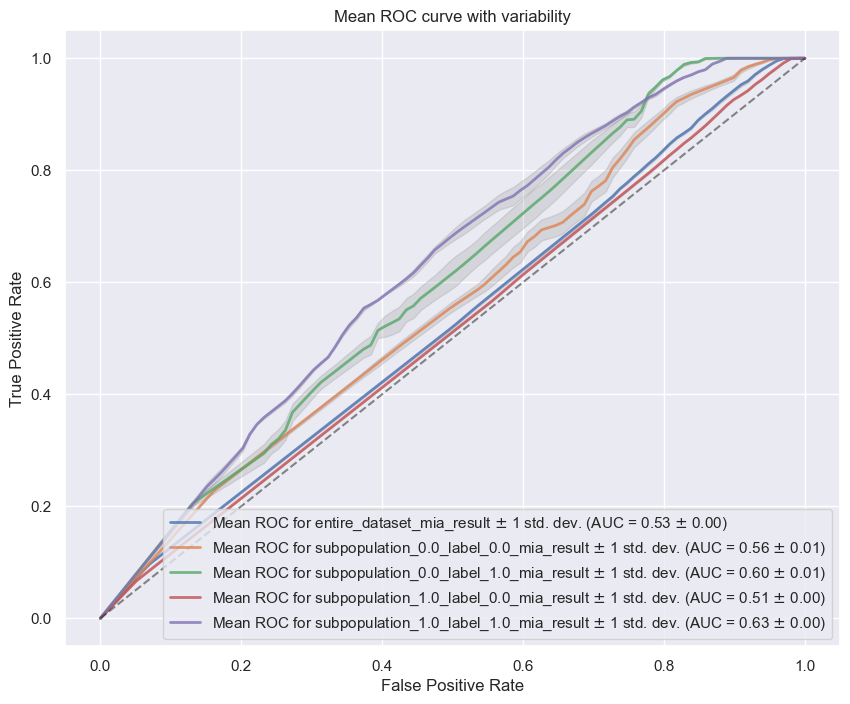

In [56]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.06
  Positive predictive value: 0.58
  Optimal thershold: -0.9808292530117262
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -0.5596157879354228
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -0.5596157879354228
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy R

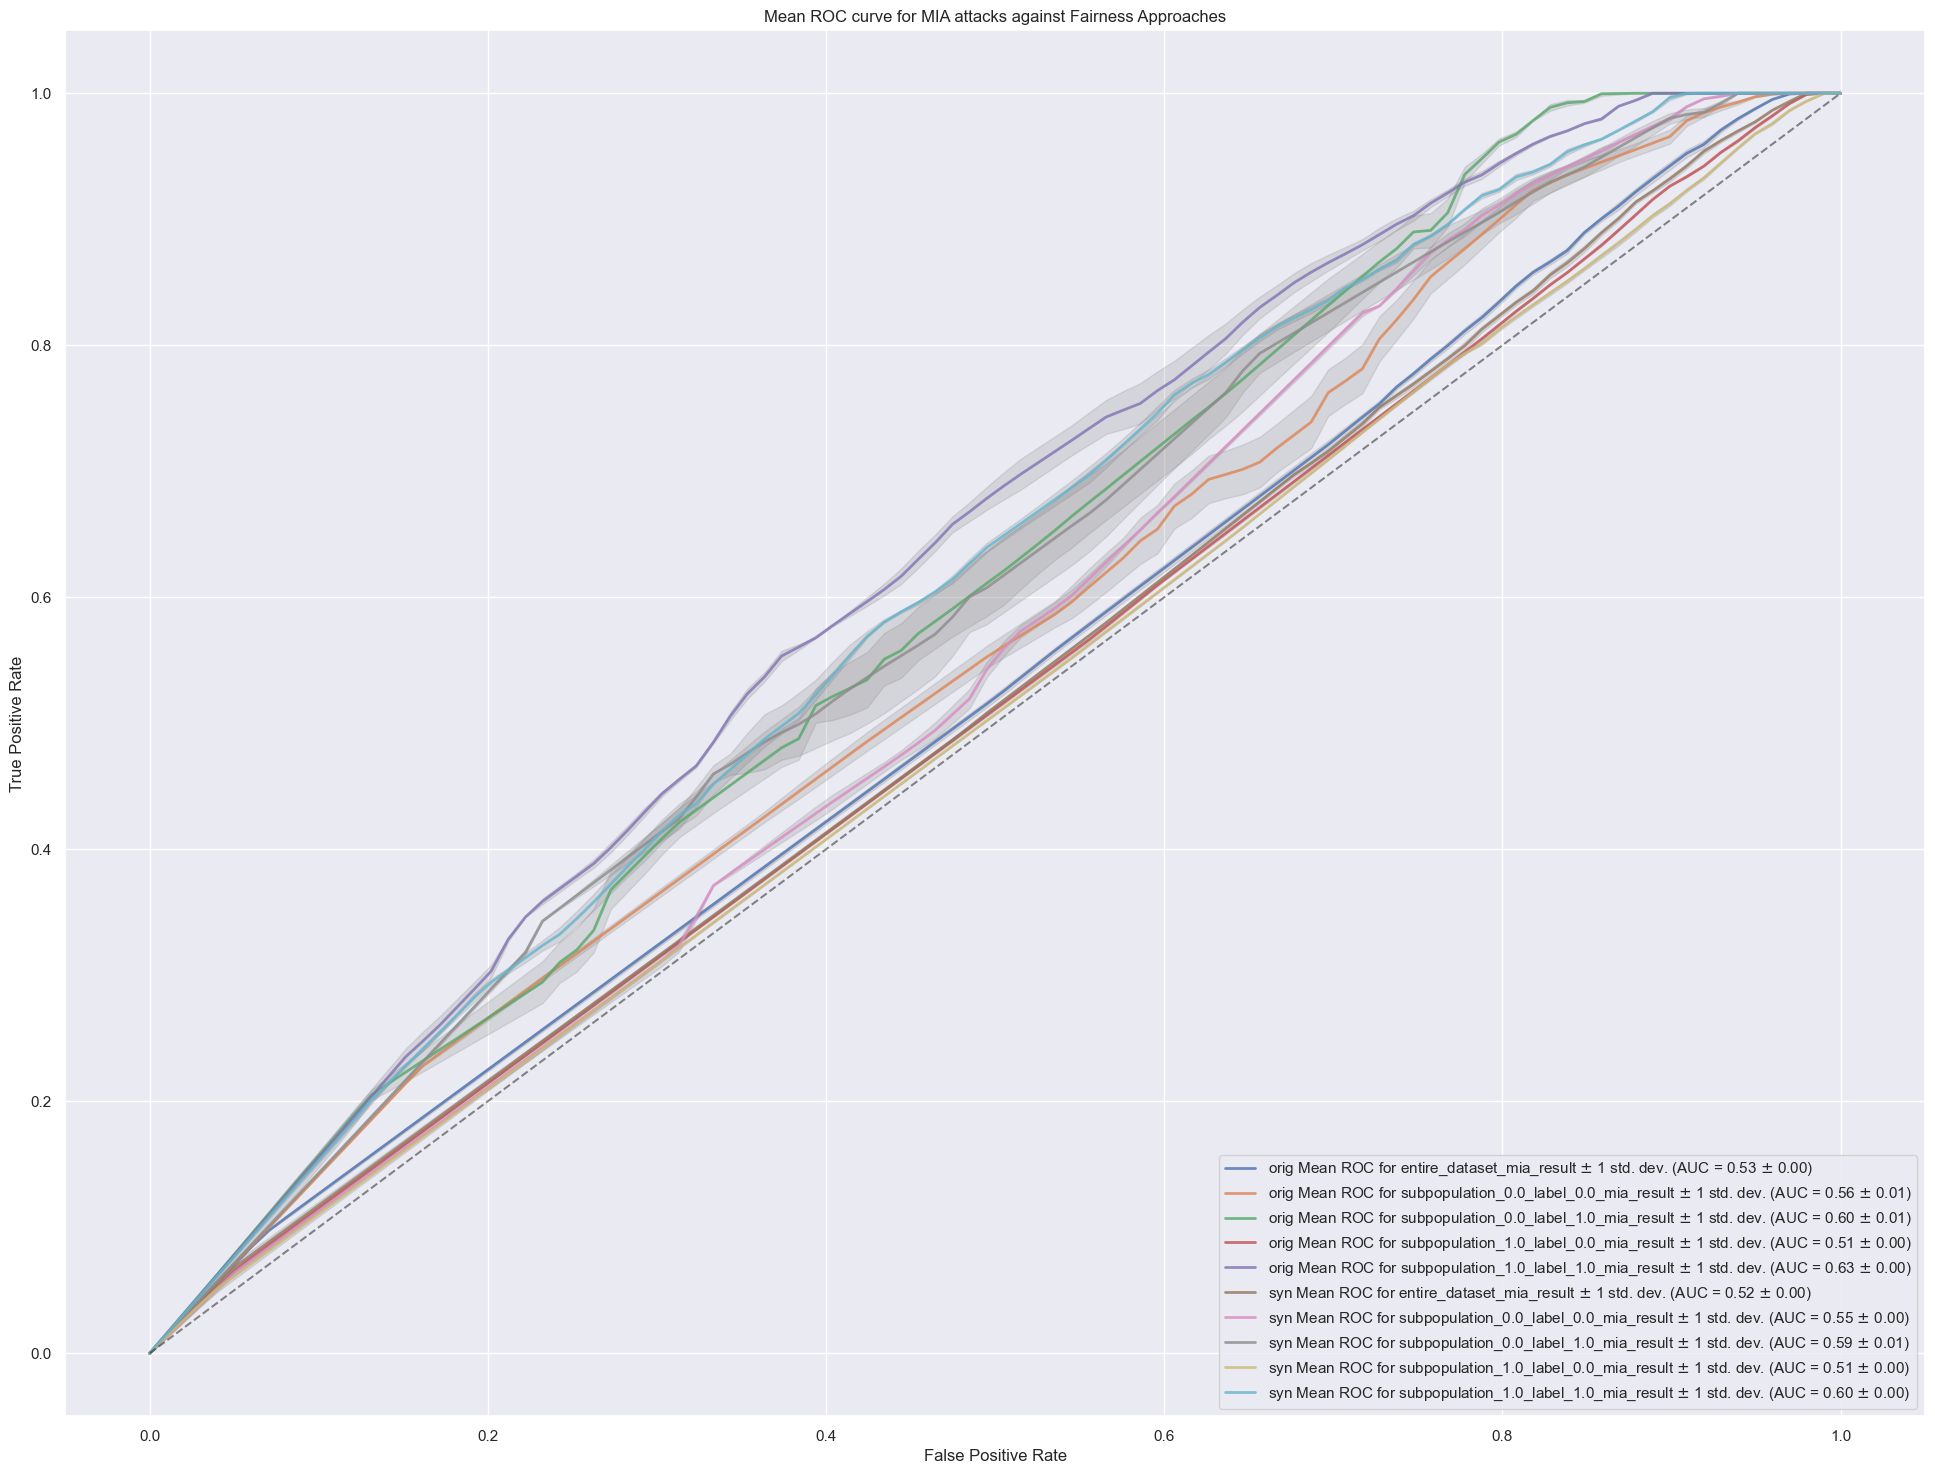

In [57]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

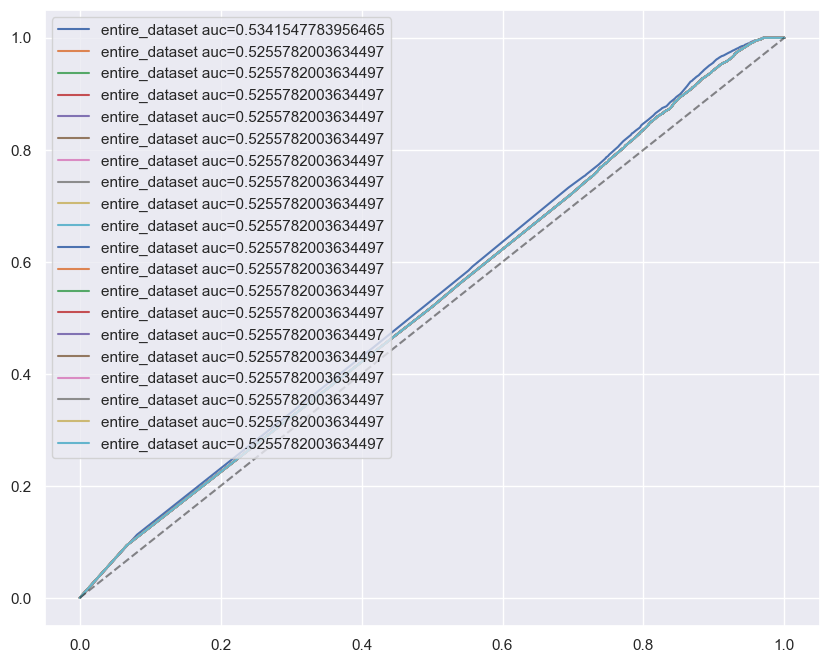

In [58]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [59]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [60]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5260070292650596,
 'entire_dataset_label_0.0_mia_auc': 0.5167308166828468,
 'entire_dataset_label_1.0_mia_auc': 0.6215333506520895,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5598513941010215,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5979124631117715,
 'subpopulation_1.0_label_0.0_mia_auc': 0.5149444090291565,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6252284929751343}

In [61]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.526007,0.516731,0.621533,0.559851,0.597912,0.514944,0.625228
syn,0.518178,0.510735,0.602184,0.550030,0.591997,0.510319,0.604320
dir,0.497626,0.473300,0.617409,0.612679,0.646906,0.465131,0.610334
rew,0.519059,0.509229,0.622625,0.565563,0.595293,0.507194,0.629224
egr,0.515022,0.510196,0.568234,0.558477,0.560447,0.508262,0.569815


<Axes: xlabel='Classifier MIA Attacks'>

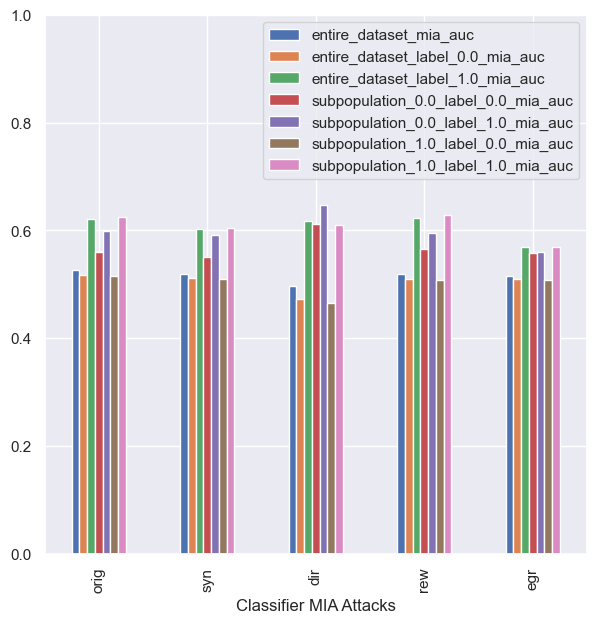

In [62]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [63]:
# Creating data structures to plot point categorical plot from seaborn

In [64]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [65]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.057672096689437735,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101,
  0.04381240147136101],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.0330392165116018,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598776643,
  0.027996666598

In [66]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.057672096689437735],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],
 ['orig', 'entire_dataset', 0.04381240147136101],

In [67]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.057672
1,orig,entire_dataset,0.043812
2,orig,entire_dataset,0.043812
3,orig,entire_dataset,0.043812
4,orig,entire_dataset,0.043812
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.117302
696,egr,subpopulation_1.0_label_1.0,0.117302
697,egr,subpopulation_1.0_label_1.0,0.117302
698,egr,subpopulation_1.0_label_1.0,0.117302


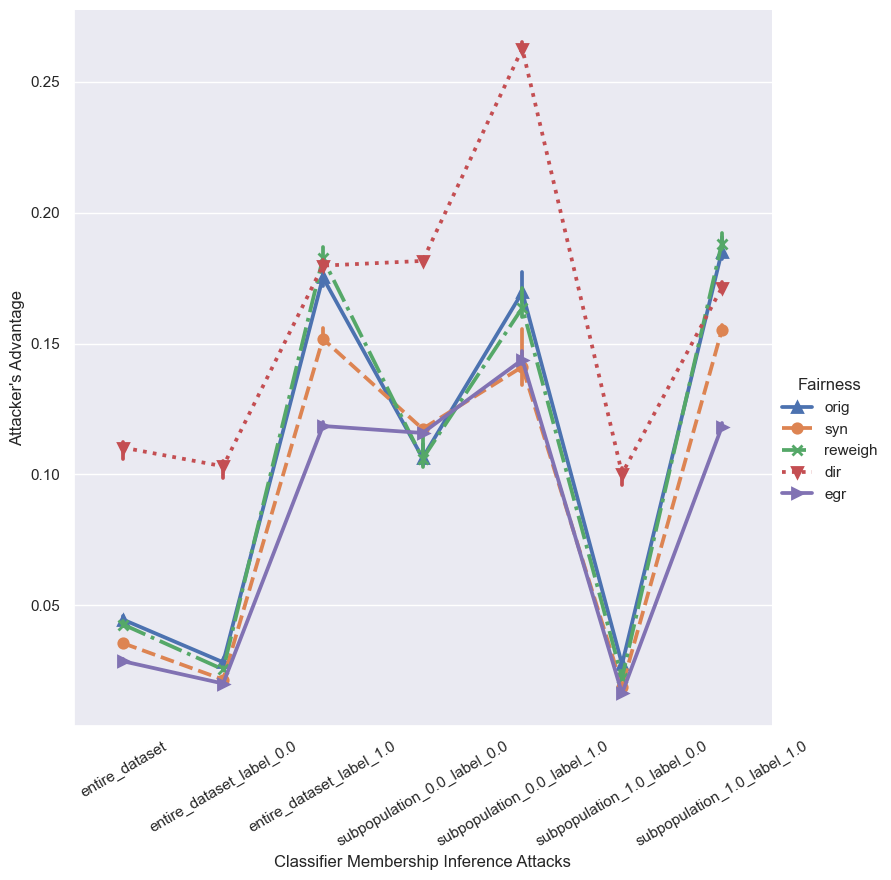

In [68]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


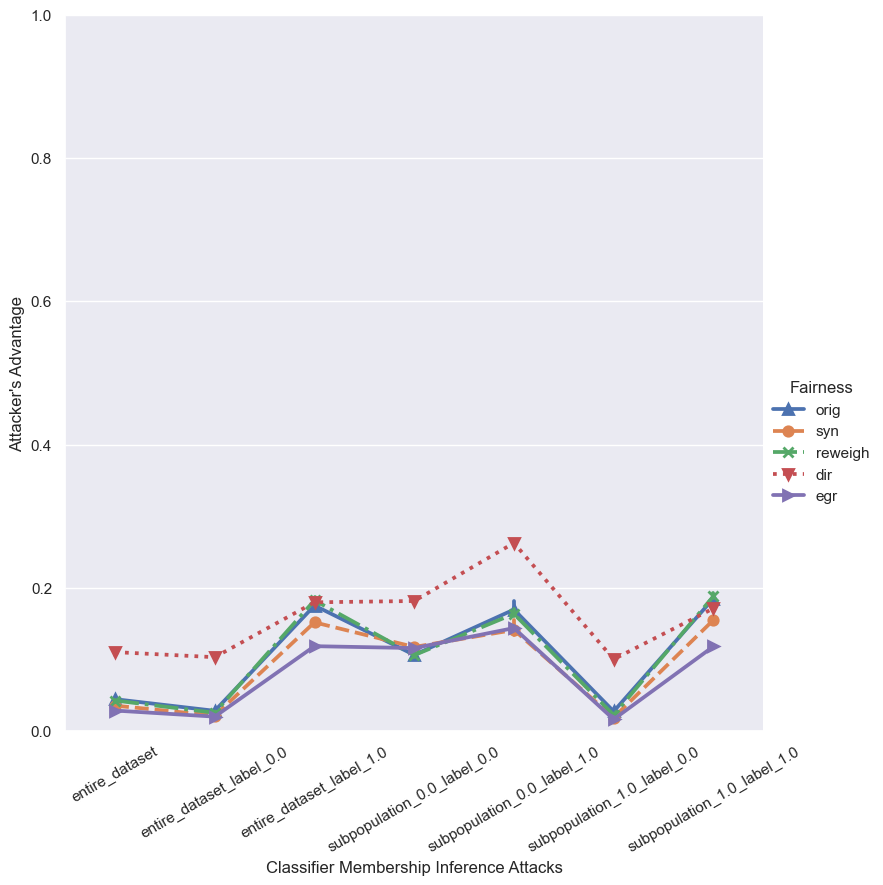

In [69]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [70]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.057672,0.033039,0.237376,0.157490,0.241193,0.028933,0.238935
1,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
2,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
3,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
4,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
5,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
6,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
7,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
8,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231
9,0.043812,0.027997,0.172009,0.103643,0.165870,0.027405,0.182231


In [71]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [72]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.04450538623226484,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.0282487940944179,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.17527708287802346,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.10633537827239439,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.16963601804580436,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.027481118902839757,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.18506642806835377}

In [73]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.044505,0.028249,0.175277,0.106335,0.169636,0.027481,0.185066
syn,0.035483,0.021638,0.151810,0.117418,0.141146,0.018897,0.155041
dir,0.110250,0.103131,0.179790,0.181594,0.262686,0.100292,0.171272
rew,0.042627,0.025511,0.182552,0.105965,0.163692,0.022304,0.188237
egr,0.028616,0.020129,0.118525,0.115862,0.143852,0.016380,0.118134


<Axes: xlabel='Classifier MIA Attacks'>

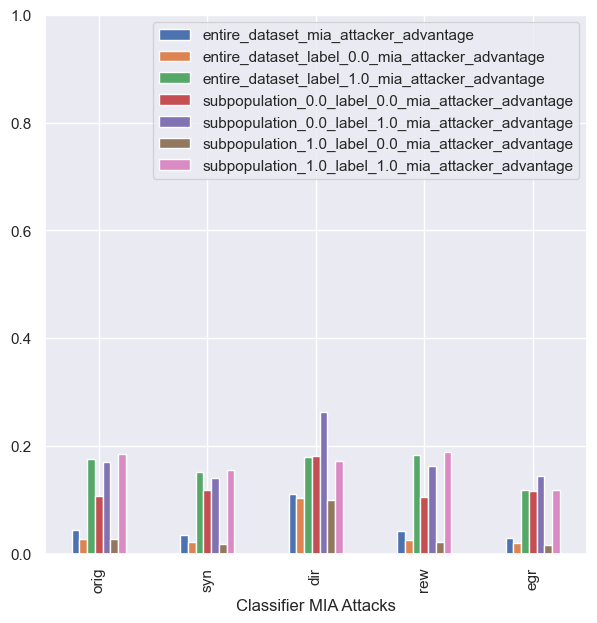

In [74]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [75]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [76]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5811039620724686],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset', 0.583843329253366],
 ['orig', 'entire_dataset_label_0.0', 0

In [77]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.581104
1,orig,entire_dataset,0.583843
2,orig,entire_dataset,0.583843
3,orig,entire_dataset,0.583843
4,orig,entire_dataset,0.583843
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.573082
696,egr,subpopulation_1.0_label_1.0,0.573082
697,egr,subpopulation_1.0_label_1.0,0.573082
698,egr,subpopulation_1.0_label_1.0,0.573082


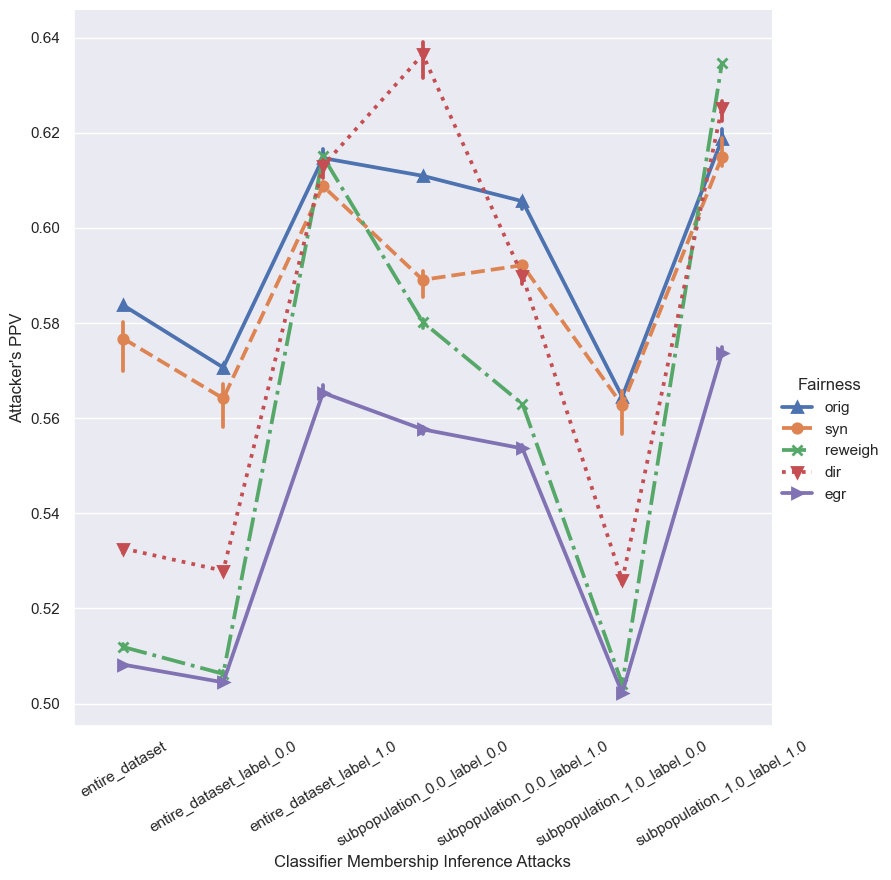

In [78]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [79]:
import pandas as pd

In [80]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30443,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30444,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30445,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30446,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [81]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.834800
1.0  1.0       0.107922
0.0  0.0       0.038492
0.0  1.0       0.018786
Name: proportion, dtype: float64

In [82]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30443,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30444,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30445,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30446,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## DT Accuracy

In [83]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

[INFO]: training decision tree
Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       617
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93       617
   macro avg       0.50      0.47      0.48       617
weighted avg       1.00      0.93      0.96       617

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     12653
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98     12653
   macro avg       0.50      0.49      0.50     12653
weighted avg       1.00      0.98      0.99     12653

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86       283

    accuracy                           0.75      

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: Undefin

{'train_0_0': 0.9319286871961102,
 'train_1_0': 0.980953133644195,
 'train_0_1': 0.7526501766784452,
 'train_1_1': 0.6552962298025135,
 'test_0_0': 0.827027027027027,
 'test_1_0': 0.9585585585585585,
 'test_0_1': 0.629757785467128,
 'test_1_1': 0.48111455108359136}

In [ ]:
# train_test_egr